##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic regression: Predict fuel efficiency

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/regression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [3]:
# Use seaborn for pairplot
!pip install -q seaborn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [9]:
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.0


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First download and import the dataset using pandas:

In [3]:
train = pd.read_csv('..\\kaggle_data\\train.csv')
test = pd.read_csv('..\\kaggle_data\\test.csv')
smpl_sub = pd.read_csv('..\\kaggle_data\\sample_submission.csv')

In [4]:
dataset = train.copy()
dataset.tail()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
299995,499993,A,B,A,C,B,B,A,E,E,...,0.269578,0.258655,0.363598,0.300619,0.340516,0.235711,0.383477,0.215227,0.793630,8.343538
299996,499996,A,B,A,C,B,B,A,E,E,...,0.197211,0.257024,0.574304,0.227035,0.322583,0.286094,0.324874,0.306933,0.230902,7.851861
299997,499997,A,B,A,C,B,B,A,E,C,...,0.449482,0.386172,0.476217,0.135947,0.502730,0.235788,0.316671,0.250286,0.349041,7.600558
299998,499998,A,B,B,C,B,B,A,D,E,...,0.363130,0.324132,0.229017,0.220888,0.515304,0.389391,0.245234,0.303895,0.481138,8.272095
299999,499999,A,A,B,A,B,D,A,E,C,...,0.734712,0.404145,0.497719,0.497974,0.782585,0.751251,0.608412,0.712868,0.452400,6.025685


### Clean the data

The dataset contains a few unknown values.

In [5]:
dataset.isna().sum()

id        0
cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
target    0
dtype: int64

Drop those rows to keep this initial tutorial simple.

In [6]:
dataset = dataset.dropna()

The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:

Note: You can set up the `keras.Model` to do this kind of transformation for you. That's beyond the scope of this tutorial. See the [preprocessing layers](../structured_data/preprocessing_layers.ipynb) or [Loading CSV data](../load_data/csv.ipynb) tutorials for examples.

In [12]:
columns = dataset.columns
cat_features = dataset.columns[:10]
cat_features
for feature in cat_features:
    le = LabelEncoder()
    le.fit(dataset[feature])
    dataset[feature] = le.transform(dataset[feature])

In [10]:
#dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [13]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,F,G,H,I,J,K,L,M,N,O
299995,299995,0,1,0,2,1,1,0,4,4,...,0,0,0,0,0,0,1,0,0,0
299996,299996,0,1,0,2,1,1,0,4,4,...,0,0,0,0,0,0,1,0,0,0
299997,299997,0,1,0,2,1,1,0,4,2,...,0,0,0,0,0,0,0,1,0,0
299998,299998,0,1,1,2,1,1,0,3,4,...,1,0,0,0,0,0,0,0,0,0
299999,299999,0,0,1,0,1,3,0,4,2,...,0,0,0,0,0,1,0,0,0,0


### Split the data into train and test

Now split the dataset into a training set and a test set.

Use the test set in the final evaluation of our models.

In [14]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are each functions of eachother.

In [16]:
#sns.pairplot(train_dataset[test_dataset.columns], diag_kind='kde')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000223A9773948> (for post_execute):


KeyboardInterrupt: 

Also look at the overall statistics, note how each feature covers a very different range:

In [ ]:
train_dataset.describe().transpose()

### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [17]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('target')
test_labels = test_features.pop('target')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [16]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable. 

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [18]:
normalizer = preprocessing.Normalization()

Then `.adapt()` it to the data:

In [19]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [20]:
print(normalizer.mean.numpy())

[150006.3        0.061      0.457      0.078      1.338      1.003
      1.927      0.029      3.875      2.956      0.525      0.507
      0.444      0.446      0.455      0.508      0.479      0.456
      0.459      0.527      0.505      0.53       0.524      0.503
      0.045      0.012      0.001      0.         0.         0.358
      0.035      0.082      0.167      0.023      0.07       0.141
      0.033      0.014      0.021]


When the layer is called it returns the input data, with each feature independently normalized:

In [21]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[112692.        1.        0.        0.        0.        1.        1.
       0.        4.        2.        0.48      0.55      0.55      0.2
       0.28      0.65      0.38      0.43      0.47      0.73      0.36
       0.72      0.35      0.72      1.        0.        0.        0.
       0.        0.        0.        0.        0.        0.        0.
       0.        0.        0.        0.  ]]

Normalized: [[-0.43  3.91 -0.92 -0.29 -1.34 -0.02 -0.93 -0.14  0.24 -0.54 -0.21  0.2
   0.52 -1.05 -0.86  0.6  -0.52 -0.14  0.06  1.02 -0.74  0.81 -0.81  0.98
   4.63 -0.11 -0.03 -0.02 -0.02 -0.75 -0.19 -0.3  -0.45 -0.15 -0.27 -0.4
  -0.18 -0.12 -0.15]]


## Linear regression

Before building a DNN model, start with a linear regression.

### One Variable

Start with a single-variable linear regression, to predict `MPG` from `Horsepower`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input `horsepower`.
* Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the horsepower `Normalization` layer:

In [21]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

Build the sequential model:

In [22]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `MPG` from `Horsepower`.

Run the untrained model on the first 10 horse-power values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [23]:
horsepower_model.predict(horsepower[:10])

array([[ 0.061],
       [ 0.034],
       [-0.112],
       [ 0.085],
       [ 0.077],
       [ 0.03 ],
       [ 0.091],
       [ 0.077],
       [ 0.02 ],
       [ 0.034]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [24]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use `Model.fit()` to execute the training:

In [25]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 8.83 s, sys: 769 ms, total: 9.6 s
Wall time: 7.77 s


Visualize the model's training progress using the stats stored in the `history` object.

In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804656,4.175353,95
96,3.805574,4.190994,96
97,3.802880,4.197964,97
98,3.805901,4.177857,98
99,3.803563,4.195875,99


In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

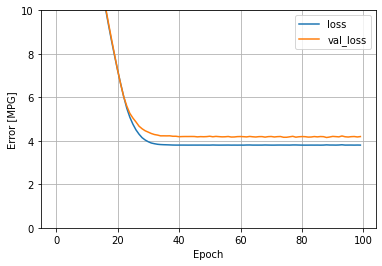

In [28]:
plot_loss(history)

Collect the results on the test set, for later:

In [29]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [30]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [31]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

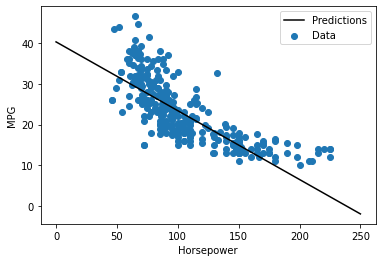

In [32]:
plot_horsepower(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [22]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [23]:
linear_model.predict(train_features[:10])

array([[-0.764],
       [-0.092],
       [-3.008],
       [-0.065],
       [ 1.094],
       [ 0.547],
       [ 0.137],
       [ 0.248],
       [-1.518],
       [-1.638]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(9,1)`.

In [24]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(39, 1) dtype=float32, numpy=
array([[ 0.168],
       [-0.313],
       [-0.085],
       [-0.129],
       [-0.294],
       [-0.009],
       [ 0.007],
       [-0.133],
       [ 0.324],
       [-0.128],
       [ 0.301],
       [-0.209],
       [-0.302],
       [-0.318],
       [ 0.227],
       [ 0.345],
       [-0.28 ],
       [ 0.341],
       [-0.235],
       [ 0.163],
       [ 0.364],
       [-0.339],
       [-0.024],
       [-0.384],
       [ 0.084],
       [-0.022],
       [ 0.19 ],
       [ 0.043],
       [-0.024],
       [-0.377],
       [ 0.051],
       [-0.029],
       [ 0.212],
       [-0.336],
       [ 0.378],
       [ 0.306],
       [-0.002],
       [ 0.179],
       [-0.36 ]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `horsepower` model:

In [32]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [33]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=2,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
6000/6000 - 9s - loss: 0.9000 - val_loss: 0.9266
Epoch 2/100
6000/6000 - 9s - loss: 0.8987 - val_loss: 0.9555
Epoch 3/100
6000/6000 - 9s - loss: 0.9018 - val_loss: 0.9145
Epoch 4/100
6000/6000 - 9s - loss: 0.9026 - val_loss: 0.8532
Epoch 5/100
6000/6000 - 10s - loss: 0.9003 - val_loss: 1.1083
Epoch 6/100
6000/6000 - 10s - loss: 0.8974 - val_loss: 0.9215
Epoch 7/100
6000/6000 - 10s - loss: 0.9032 - val_loss: 0.8740
Epoch 8/100
6000/6000 - 9s - loss: 0.9014 - val_loss: 0.8708
Epoch 9/100
6000/6000 - 9s - loss: 0.9041 - val_loss: 0.9603
Epoch 10/100
6000/6000 - 9s - loss: 0.9018 - val_loss: 0.9296
Epoch 11/100
6000/6000 - 9s - loss: 0.9014 - val_loss: 0.9275
Epoch 12/100
6000/6000 - 10s - loss: 0.9012 - val_loss: 0.9488
Epoch 13/100
6000/6000 - 9s - loss: 0.9021 - val_loss: 0.8705
Epoch 14/100
6000/6000 - 10s - loss: 0.8995 - val_loss: 0.8636
Epoch 15/100
6000/6000 - 9s - loss: 0.8986 - val_loss: 0.9132
Epoch 16/100
6000/6000 - 10s - loss: 0.9013 - val_loss: 0.8874
Epoch 17/10

Using all the inputs achieves a much lower training and validation error than the `horsepower` model: 

In [34]:
plot_loss(history)

NameError: name 'plot_loss' is not defined

Collect the results on the test set, for later:

In [35]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

NameError: name 'test_results' is not defined

## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [36]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### One variable

Start with a DNN model for a single input: "Horsepower"

In [41]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [42]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model:

In [43]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 9.31 s, sys: 580 ms, total: 9.89 s
Wall time: 7.84 s


This model does slightly better than the linear-horsepower model.

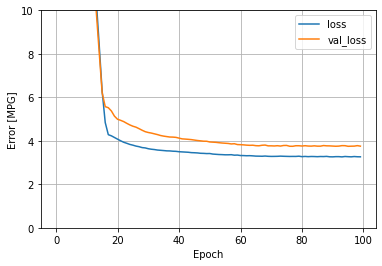

In [44]:
plot_loss(history)

If you plot the predictions as a function of `Horsepower`, you'll see how this model takes advantage of the nonlinearity provided by the hidden layers:

In [45]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

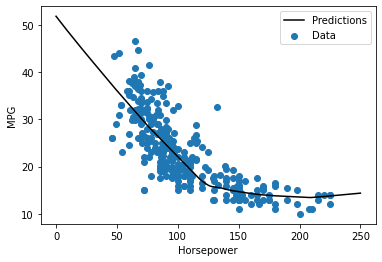

In [46]:
plot_horsepower(x, y)

Collect the results on the test set, for later:

In [47]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [37]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 39)                79        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2560      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 6,864
Trainable params: 6,785
Non-trainable params: 79
_________________________________________________________________


In [39]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=2, epochs=100)

Epoch 1/100
6000/6000 - 14s - loss: 0.7243 - val_loss: 0.7209
Epoch 2/100
6000/6000 - 12s - loss: 0.7228 - val_loss: 0.7255
Epoch 3/100
6000/6000 - 12s - loss: 0.7217 - val_loss: 0.7211
Epoch 4/100
6000/6000 - 12s - loss: 0.7216 - val_loss: 0.7191
Epoch 5/100
6000/6000 - 12s - loss: 0.7205 - val_loss: 0.7281
Epoch 6/100
6000/6000 - 12s - loss: 0.7199 - val_loss: 0.7202
Epoch 7/100
6000/6000 - 12s - loss: 0.7192 - val_loss: 0.7177
Epoch 8/100
6000/6000 - 12s - loss: 0.7189 - val_loss: 0.7195
Epoch 9/100
6000/6000 - 12s - loss: 0.7183 - val_loss: 0.7199
Epoch 10/100
6000/6000 - 12s - loss: 0.7175 - val_loss: 0.7213
Epoch 11/100
6000/6000 - 12s - loss: 0.7174 - val_loss: 0.7252
Epoch 12/100
6000/6000 - 12s - loss: 0.7161 - val_loss: 0.7281
Epoch 13/100
6000/6000 - 12s - loss: 0.7162 - val_loss: 0.7164
Epoch 14/100
6000/6000 - 12s - loss: 0.7151 - val_loss: 0.7205
Epoch 15/100
6000/6000 - 12s - loss: 0.7150 - val_loss: 0.7193
Epoch 16/100
6000/6000 - 12s - loss: 0.7144 - val_loss: 0.7195
E

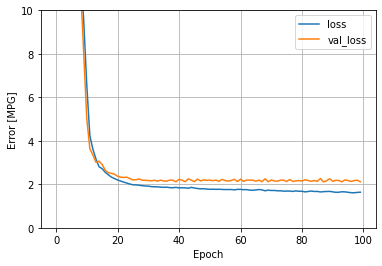

In [50]:
plot_loss(history)

Collect the results on the test set:

In [51]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Now that all the models are trained check the test-set performance and see how they did:

In [52]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.638829
linear_model,2.501205
dnn_horsepower_model,2.931511
dnn_model,1.799211


These results match the validation error seen during training.

### Make predictions

Finally, predict have a look at the errors made by the model when making predictions on the test set:

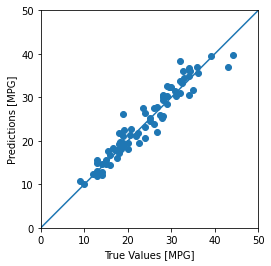

In [53]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It looks like the model predicts reasonably well. 

Now take a look at the error distribution:

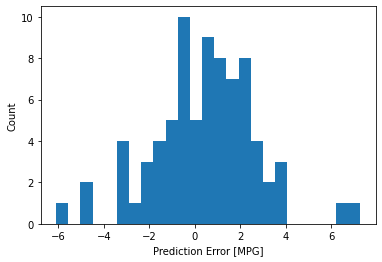

In [54]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model save it for later use:

In [55]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


If you reload the model, it gives identical output:

In [56]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [57]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.638829
linear_model,2.501205
dnn_horsepower_model,2.931511
dnn_model,1.799211
reloaded,1.799211


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

* [Mean Squared Error (MSE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanSquaredError) and [Mean Absolute Error (MAE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanAbsoluteError) are common loss functions used for regression problems. Mean Absolute Error is less sensitive to outliers. Different loss functions are used for classification problems.
* Similarly, evaluation metrics used for regression differ from classification.
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* Overfitting is a common problem for DNN models, it wasn't a problem for this tutorial. See the [overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.
